# Getting Started

This guide will make use of the dataset generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model.
The dataset consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine - i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation are considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data are contaminated with sensor noise.

The engine is operating normally at the start of each time series and starts to degrade at some point during the series. In the training set, the degradation grows in magnitude until a predefined threshold is reached beyond which it is not preferable to operate the engine. In the test set, the time series ends some time prior to complete degradation. The objective of the competition is to predict the number of operational cycles after the last cycle that the engine will continue to operate properly.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle; each column is a different variable.

Dataset structure

* Unit: Engine number [-]
* t: time [cycles]
* 0p1: operational setting 1
* op2: operational setting 2
* op3: operational setting 3
* s1: Sensor measurement 1
* s2: Sensor measurement 2
...
* s20: sensor measurement 20


In the first set of data, there are 100 train trajectories and 100 test trajectories.



[1] A. Saxena, M. Ieee, K. Goebel, D. Simon, and N. Eklund, “Damage Propagation Modeling for Aircraft Engine Prognostics,” Response, 2008. 

## Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from temporis.dataset.ts_dataset import AbstractTimeSeriesDataset
from temporis.dataset.CMAPSS import (engines, operation_mode, process_file_test,
                                     process_file_train, sensor_indices)

from temporis.dataset.analysis.null import (null_proportion, null_proportion_per_life)
from temporis.dataset.analysis.variance import variance_information

from temporis.transformation.features.selection import (ByNameFeatureSelector, 
                                                        PandasNullProportionSelector,
                                                        PandasVarianceThreshold)
from temporis.transformation.features.scalers import MinMaxScaler
from temporis.transformation.features.imputers import (ForwardFillImputer,
                                                         MeanImputer,
                                                         RemoveInf,
                                                         PerColumnImputer)
from temporis.transformation.features.extraction import RollingStatistics
from temporis.transformation import Transformer, Concatenate

from temporis.iterators.iterators import (WindowedDatasetIterator)
from temporis.iterators.shufflers import NotShuffled
from temporis.iterators.batcher import Batcher
from temporis.iterators.utils import true_values

from temporis.models.keras import tf_regression_dataset
from temporis.transformation.functional.pipeline.utils import plot_pipeline

2021-12-16 11:45:15.602872: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-16 11:45:15.602890: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Dataset

The Dataset comes in a space separated tabular file. The functions `process_file_train` and `process_file_test` receive the filename of the dataset file and return a `pd.DataFrame` with the pre-processed data. The `UnitNumber` column is a life identifier.

In order to define a dataset you should subclass `AbstractLivesDataset` and define three methods:

  * `__getitem__(self, i)`: This method should return the i-th life 
  * `nlives(self)`: In this method should return the total number of lives present in the dataset

In [4]:
class CMAPSSDataset(AbstractTimeSeriesDataset):
    def __init__(self, train=True, model=None):
        super().__init__()
        if model is not None:
            if model not in operation_mode:
                raise ValueError(
                    f'Invalid model: valid model are {list(operation_mode.keys())}')
        if train:
            processing_fun = process_file_train
        else:
            processing_fun = process_file_test
        self.lives = []
        for engine in engines:
            if model is not None and engine != model:
                continue
            for _, g in processing_fun(engine).groupby('UnitNumber'):
                g.drop(columns=['UnitNumber'], inplace=True)
                self.lives.append(g)
    
    def get_time_series(self, i):
        return self.lives[i]

    def number_of_samples_of_time_series(self):
        return len(self.lives)
    
    @property
    def n_time_series(self):
        return len(self.lives)


In [5]:
train_dataset = CMAPSSDataset(train=True, model='FD001')
validation_dataset = CMAPSSDataset(train=False, model='FD001')

### Number of lives in the training set

In [6]:
len(train_dataset)

100

### Number of lives in the validation set

In [7]:
len(validation_dataset)

100

## Dataset analysis

### Missing values
Usually, the information of sensors is incomplete and this causes numerous missing values in the features. This library provides some useful functions to analyse the proportion of the missing values for each feature for each life. In some cases, if the feature values are missing in multiple lives, that feature can be discarded.

Luckily in the NASA dataset, we don't have any missing values:

In [8]:
df, null_per_life = null_proportion(train_dataset)
df

,Feature,Max Null Proportion,Mean Null Proportion,Number of lives with more than 80% missing
0,OpSet3,0.0,0.0,0
14,SensorMeasure13,0.0,0.0,0
25,SensorMeasure5,0.0,0.0,0
24,SensorMeasure11,0.0,0.0,0
23,SensorMeasure10,0.0,0.0,0
22,SensorMeasure14,0.0,0.0,0
21,SensorMeasure21,0.0,0.0,0
20,OpMode,0.0,0.0,0
19,SensorMeasure6,0.0,0.0,0
18,Cycle,0.0,0.0,0


In [9]:
null_proportion_per_life(train_dataset)

,Life,Number of features,Number of completely null features,N of features with 50% null,N of features with 25% null,Mean null propotion
0,0,27,0,0,0,0.0
63,63,27,0,0,0,0.0
73,73,27,0,0,0,0.0
72,72,27,0,0,0,0.0
71,71,27,0,0,0,0.0
...,...,...,...,...,...,...
30,30,27,0,0,0,0.0
29,29,27,0,0,0,0.0
28,28,27,0,0,0,0.0
27,27,27,0,0,0,0.0


### Variance
Another possibility is that sensors do not vary equally in a diverse set of lives. Another function obtains information about the variance of each feature per each life. If a feature variance is zero in many lives, maybe it is a good idea to remove it.

In the NASA dataset, we can see that some of the features have a zero variance in some of the lives.

In [10]:
df, var_per_life = variance_information(train_dataset)
df.sort_values(by='Mean std')

,Feature,Min std,Mean std,Max std
0,OpSet3,0.000000,0.000000e+00,0.000000e+00
17,SensorMeasure18,0.000000,0.000000e+00,0.000000e+00
20,OpMode,0.000000,0.000000e+00,0.000000e+00
9,SensorMeasure19,0.000000,0.000000e+00,0.000000e+00
4,SensorMeasure16,0.000000,5.321406e-18,1.393232e-17
23,SensorMeasure10,0.000000,2.203638e-16,6.677487e-16
25,SensorMeasure5,0.000000,1.264424e-15,3.566673e-15
2,SensorMeasure1,0.000000,2.280172e-15,1.141103e-13
1,OpSet2,0.000269,2.897551e-04,3.239132e-04
19,SensorMeasure6,0.000000,9.590898e-04,2.881041e-03


## Transformers

Transformers are defined using an API similar to the keras functional API.

Two tarnsformer pipelines have to be defined:
* How the data is going to be transformed
    * This transformer invovles selecting and transforming and generating features
* How the target is going to be transformed
    * This transformer involves selecting and transforming the target

### Functional API

Following the literature, the future that addresses this dataset, only a subset of the feature are going to be used to fit our model.

In [11]:
features = [train_dataset[0].columns[i] for i in sensor_indices]
features

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

The transformation of the input data will be simple, a feature scaling between -1 and 1 and imputing any missing value or non finite.

In [12]:
functional_pipe = ByNameFeatureSelector(features)
functional_pipe = MinMaxScaler((-1,1))(functional_pipe)
functional_pipe = MeanImputer()(functional_pipe)

One common approach for handling PM problems is to downplay the early stages of the execution due to the fact that that is harder to detect indication of degradation at the beggining.

For this dataset, a piece-wise linear degradation model has been validated to be suitable and effective. In general, the engine unit works normally in the early age and degrades linearly afterwards. It is assumed to have a constant RUL label in the initial period.  [1]

[1] Li, X., Ding, Q., & Sun, J. Q. (2018). Remaining useful life estimation in prognostics using deep convolution neural networks. Reliability Engineering & System Safety, 172, 1-11.

In [13]:
target_pipe = ByNameFeatureSelector(['RUL'])

In [14]:
functional_transformer = Transformer(
    transformerX=functional_pipe,
    transformerY=target_pipe)


### Fitting the transformer

The transformer must be fitted on the dataset.

In [15]:
functional_transformer.fit(train_dataset)

### Transforming a life

In [16]:
X, y, m = functional_transformer.transform(train_dataset[0])

In [17]:
X.shape

(192, 14)

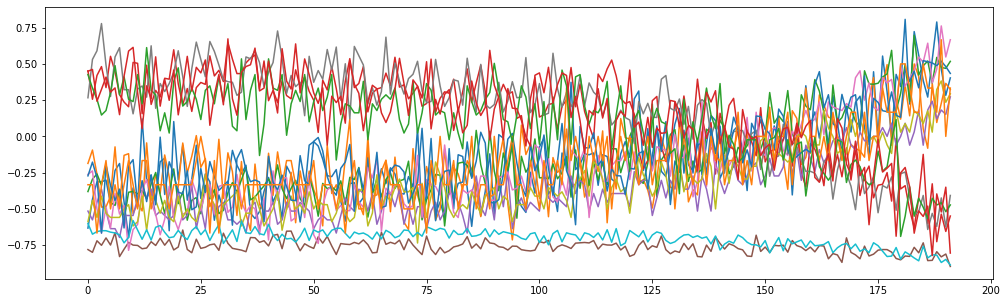

In [18]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

### More complex transformers
More complex transformers can also be constructed. For example, we may want to use the raw features but also extract some statistics from a subset of features. In this case, we are going to obtain the kurtosis and the peak coefficient using a rolling window for 3 features. There are a lot of different feature extraction and transformation steps that can be applied. I encourage you to check the documentation to discover more.

The number of features we are going to obtain at the end will be the 14 coming from the raw features and 6=2*3 coming for the two statistics computed from the selected subset of size 3.

In [19]:
raw_pipe = ByNameFeatureSelector(features)
raw_pipe = ForwardFillImputer()(raw_pipe)
raw_pipe = MinMaxScaler((-1,1), name='raw_scaled')(raw_pipe)

transformed_pipe = ByNameFeatureSelector(features[0:3])
transformed_pipe = RollingStatistics(window=15, to_compute=['kurtosis', 'peak'])(transformed_pipe)
transformed_pipe = MeanImputer()(transformed_pipe)
transformed_pipe = MinMaxScaler((-1,1), name='transformed_scaled')(transformed_pipe)


pipe = Concatenate()([raw_pipe, transformed_pipe])

target_pipe = ByNameFeatureSelector(['RUL'])

complex_transformer = Transformer(
    transformerX=pipe,
    transformerY=target_pipe)

complex_transformer.fit(train_dataset)

# It is possible to visualize the transformation pipeline

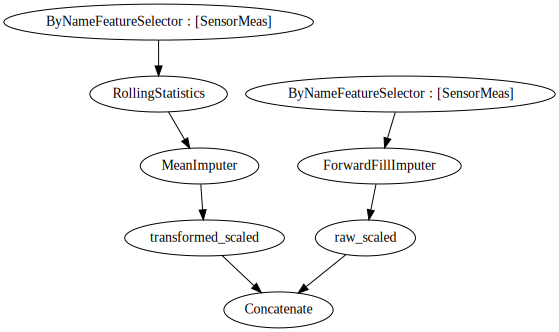

In [20]:
plot_pipeline(pipe, 'Complex transformer')

In [21]:
X, y, m = complex_transformer.transform(train_dataset[0])

The number of features as expected is 20 features: 14 from the raw features and 6 from the extracted ones

In [22]:
X.shape

(192, 20)

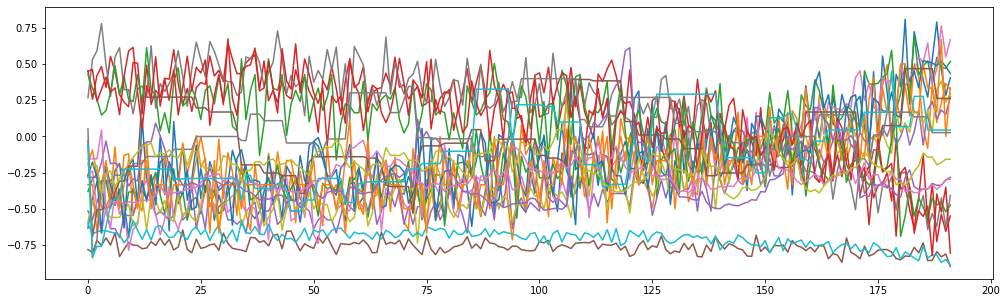

In [23]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(X);

The name of the obtained features are computed from the step names and the selected features

In [24]:
complex_transformer.columns()

Index(['raw_scaled_0_SensorMeasure2', 'raw_scaled_0_SensorMeasure3',
       'raw_scaled_0_SensorMeasure4', 'raw_scaled_0_SensorMeasure7',
       'raw_scaled_0_SensorMeasure8', 'raw_scaled_0_SensorMeasure9',
       'raw_scaled_0_SensorMeasure11', 'raw_scaled_0_SensorMeasure12',
       'raw_scaled_0_SensorMeasure13', 'raw_scaled_0_SensorMeasure14',
       'raw_scaled_0_SensorMeasure15', 'raw_scaled_0_SensorMeasure17',
       'raw_scaled_0_SensorMeasure20', 'raw_scaled_0_SensorMeasure21',
       'transformed_scaled_1_SensorMeasure2_kurtosis',
       'transformed_scaled_1_SensorMeasure2_peak',
       'transformed_scaled_1_SensorMeasure3_kurtosis',
       'transformed_scaled_1_SensorMeasure3_peak',
       'transformed_scaled_1_SensorMeasure4_kurtosis',
       'transformed_scaled_1_SensorMeasure4_peak'],
      dtype='object')

## Iterators

### Lives iterator

The dataset can be iterated. Each element of the iteration is life in stored in `pd.DataFrame` which contains all the features

In [25]:
train_dataset[0].columns

Index(['Cycle', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1',
       'SensorMeasure2', 'SensorMeasure3', 'SensorMeasure4', 'SensorMeasure5',
       'SensorMeasure6', 'SensorMeasure7', 'SensorMeasure8', 'SensorMeasure9',
       'SensorMeasure10', 'SensorMeasure11', 'SensorMeasure12',
       'SensorMeasure13', 'SensorMeasure14', 'SensorMeasure15',
       'SensorMeasure16', 'SensorMeasure17', 'SensorMeasure18',
       'SensorMeasure19', 'SensorMeasure20', 'SensorMeasure21', 'RUL',
       'OpMode'],
      dtype='object')

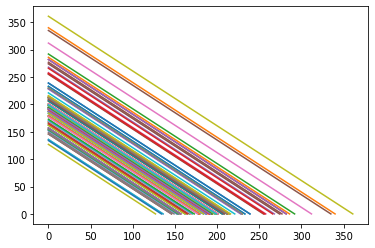

In [26]:
fig, ax = plt.subplots()
for life in train_dataset:
    ax.plot(life['RUL'].values)

### Transformed dataset

In [27]:
transformed_ds = train_dataset.map(complex_transformer)
X, y, sw = transformed_ds[0]
    

### WindowedDatasetIterator
The windowed dataset iterator provides a way of iterating the transformed dataset trough an sliding window. The sample for the i-th element, provides the (window-1) elements of the window. It also provides capabilities to shuffle in diverse ways the how the samples are delivered by the iterator.

In [28]:
window = 7
iterator = WindowedDatasetIterator(
    transformed_ds,
    window,
    step=1,
    output_size=1,
    shuffler=NotShuffled())

X, y, sw = next(iterator)

Since we are using the functional_transformer that only has 14 feature and a window size of 7 samples. The output of one element of the iterator wil be a matrix ox size (7 x14)

In [29]:
X.shape

(7, 20)

## Batcher

The batcher class make use of the `WindowedDatasetIterator` to generate batches of samples.

In [30]:
window = 25
batch_size = 66
step = 2
train_batcher = Batcher.new(transformed_ds,  
                            window, 
                            batch_size, 
                            step, 
                            shuffler=NotShuffled())
X, y, sw = next(train_batcher)

As expected the shape of the input data of one batch is:
* 66 due to the batch size
* 25 because the lookback window size
* 14 for the selected features in the transformer

In [31]:
X.shape

(66, 25, 20)

In [32]:
y.shape

(66, 1, 1)

### How dos a sample looks like?

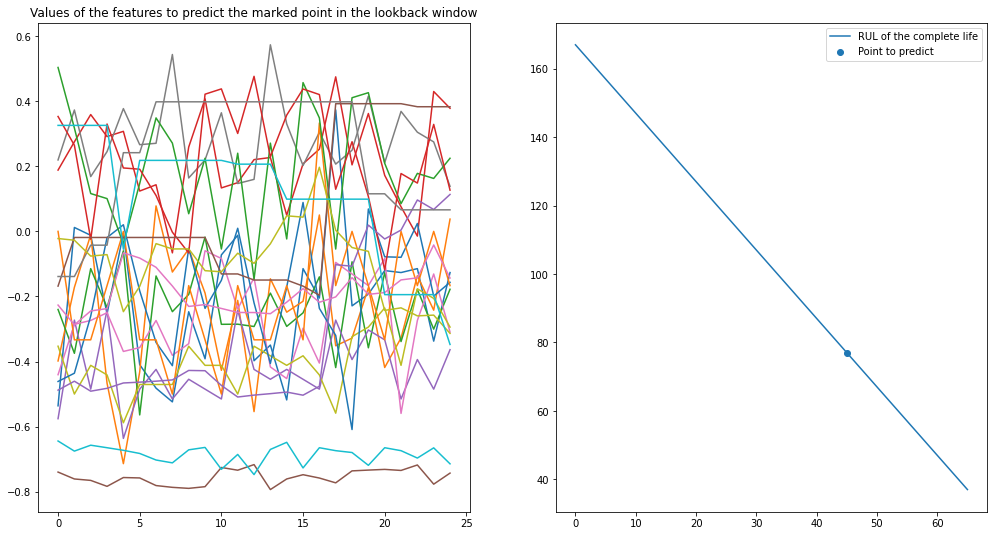

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(17, 9))
for f in range(X.shape[2]):
    ax[0].plot(X[45, :, f])
ax[0].set_title('Values of the features to predict the marked point in the lookback window')
ax[1].plot(np.squeeze(y), label='RUL of the complete life')
ax[1].scatter(x=45, y=y[45], label='Point to predict')
ax[1].legend()

## Model

There are utilities available to fit models with common machine learning frameworks

### Keras models

Let's create a simple model in keras with some FC layers. 


First of all we need to create two batchers for feeding the model.

In [34]:
from sklearn.model_selection import train_test_split

train_transformed_ds, val_transformed_ds = train_test_split(transformed_ds, train_size=0.85)

window = 7
train_iterator = WindowedDatasetIterator(
    train_transformed_ds,
    window,
    step=1,
    output_size=1,
    shuffler=NotShuffled())

val_iterator = WindowedDatasetIterator(
    val_transformed_ds,
    window,
    step=1,
    output_size=1,
    shuffler=NotShuffled())

In [35]:
import tensorflow as tf


inputs = tf.keras.Input(shape=iterator.input_shape)
x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(32, activation=tf.nn.relu)(x)
outputs = tf.keras.layers.Dense(1, activation=tf.nn.relu)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='mae')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7, 20)]           0         
                                                                 
 flatten (Flatten)           (None, 140)               0         
                                                                 
 dense (Dense)               (None, 32)                4512      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


2021-12-16 11:45:25.381319: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-16 11:45:25.381338: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-16 11:45:25.381352: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lolo): /proc/driver/nvidia/version does not exist
2021-12-16 11:45:25.381548: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
tf_train_data = tf_regression_dataset(train_iterator).batch(64)
tf_val_data = tf_regression_dataset(val_iterator).batch(64)
history = model.fit(tf_train_data, validation_data=tf_val_data, epochs=12)

Epoch 1/12
267/267 [==============================] - 5s 19ms/step - loss: 80.6171 - val_loss: 44.9364
Epoch 2/12
267/267 [==============================] - 2s 8ms/step - loss: 36.5534 - val_loss: 31.8730
Epoch 3/12
267/267 [==============================] - 2s 8ms/step - loss: 32.0044 - val_loss: 32.5382
Epoch 4/12
267/267 [==============================] - 2s 8ms/step - loss: 31.6509 - val_loss: 32.5857
Epoch 5/12
267/267 [==============================] - 2s 7ms/step - loss: 31.4467 - val_loss: 32.5764
Epoch 6/12
267/267 [==============================] - 2s 8ms/step - loss: 31.2683 - val_loss: 32.5467
Epoch 7/12
267/267 [==============================] - 2s 8ms/step - loss: 31.1052 - val_loss: 32.5342
Epoch 8/12
267/267 [==============================] - 2s 8ms/step - loss: 30.9527 - val_loss: 32.5273
Epoch 9/12
267/267 [==============================] - 2s 8ms/step - loss: 30.7945 - val_loss: 32.4999
Epoch 10/12
267/267 [==============================] - 2s 8ms/step - loss: 30.629

#### Learning curves

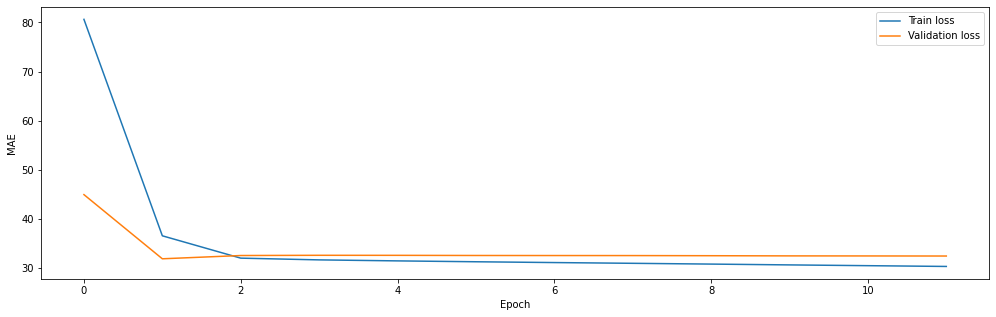

In [37]:
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(history.history['loss'], label='Train loss')
ax.plot(history.history['val_loss'], label='Validation loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MAE')
ax.legend()

#### Prediction on the validation set

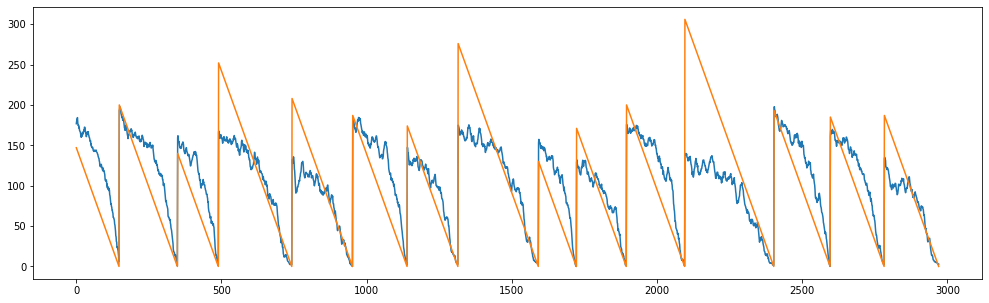

In [40]:
y_pred = np.squeeze(model.predict(tf_val_data))
y_true = np.squeeze(true_values(tf_val_data))
fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(y_pred, label='Predicted')
ax.plot(y_true, label='True values')

### Scikit-learn and gradient boosting models
Following the same API we can create scikit-learn and XGBoost models for regressing our data.

##### Scikit-learn model
In the following example we are going to create a RandomForestRegressor to predict the RUL of the same dataset

In [41]:
from sklearn.model_selection import train_test_split

train_transformed_ds, val_transformed_ds = train_test_split(transformed_ds, train_size=0.85)

window = 7
train_iterator = WindowedDatasetIterator(
    train_transformed_ds,
    window,
    step=1,
    output_size=1,
    shuffler=NotShuffled())

val_iterator = WindowedDatasetIterator(
    val_transformed_ds,
    window,
    step=1,
    output_size=1,
    shuffler=NotShuffled())

In [42]:
from sklearn.ensemble import RandomForestRegressor



X_train, y_train, sw_train = train_iterator.get_data()

model = RandomForestRegressor(max_depth=5)
model.fit(X_train, np.squeeze(y_train))

RandomForestRegressor(max_depth=5)

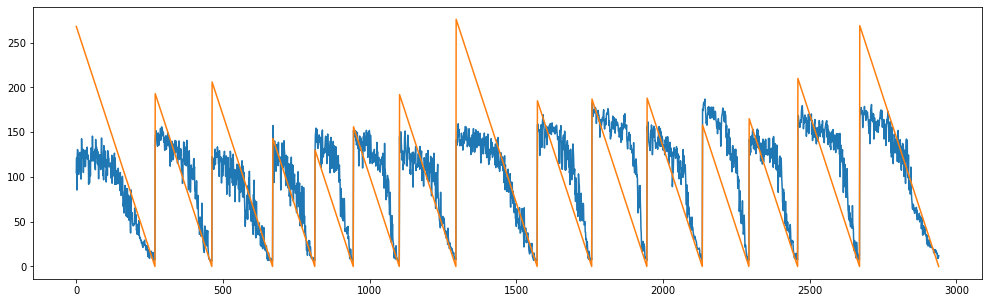

In [43]:
X_val, y_val, sw_val = val_iterator.get_data()

y_pred_rf = model.predict(X_val)

fig, ax = plt.subplots(figsize=(17, 5))
ax.plot(y_pred_rf, label='Predicted')
ax.plot(y_val, label='True values')